http://localhost:4040/

# Estimating a gravity model of international trade *(WIP)*

## Table of Contents

* Introduction
* Initialize and configure Spark
* Load and prepare data
    * Distances
    * Geography
    * GDP
    * Trade flows
    * Combine everything into one dataset
* Estimate gravity equation
* ...

## Introduction: Gravity model

https://en.wikipedia.org/wiki/Gravity_model_of_trade

Basic gravity model: 

$$ F_{ij}=G * \frac{M_i * M_j}{D_{ij}} * \eta_{ij} $$

* *F(ij)*: trade volume between countries i and j
* *G*: constant
* *M(i)*: GDP of country i
* *M(j)*: GDP of country j
* *D(ij)*: distance between countries i and j
* *eta(ij)*: error of each country i,j pair

Which can be transformed into the the following log-log regression equation with error epsilon(ij):

$$ ln(F_{ij}) = \beta_0 + \beta_1ln(M_i) + \beta_2ln(M_j) + \beta_3ln(D_{ij}) + \varepsilon_{ij} $$

## Imports

In [1]:
# Initialization and configuration
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession

# Spark
from pyspark.sql.types import *
import pyspark.sql.functions as F

## Initialize and configure Spark

In [2]:
# Configuration
conf = SparkConf().setAppName("Gravity").setMaster("local[4]")
conf.set("spark.driver.maxResultSize", "2g")
conf.set("spark.driver.memory", "2g")
conf.set("spark.executor.memory", "2g") 
conf.set("spark.executor.pyspark.memory", "2g")

# Initialization
sc = SparkContext(conf=conf)
sqlc = SQLContext(sc)
spark = SparkSession(sc)

## Load and prepare data (2018 example)

### Flows

In [349]:
# flows = spark.read.parquet("data/parquet/*")
flows = spark.read.parquet("data/parquet/full2018.parquet")

flows = flows.withColumn("YEAR", flows["PERIOD"].substr(1, 4).cast(IntegerType()))
flows = flows \
    .select("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "PRODUCT_NC", "FLOW", "YEAR", "VALUE_IN_EUROS") \
    .filter(flows["YEAR"] == 2018) \
    .filter(flows["PRODUCT_NC"] != "TOTAL") \
    .groupBy("REPORTER_ISO", "PARTNER_ISO", "TRADE_TYPE", "YEAR").agg({"VALUE_IN_EUROS": "sum"}) \

flows = flows \
    .withColumn("TRADE_VOLUME", flows["sum(VALUE_IN_EUROS)"]/1e6) \
    .drop("sum(VALUE_IN_EUROS)") \
    .fillna({"TRADE_VOLUME": 0}) \
    .cache()

In [350]:
flows.printSchema()

root
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- TRADE_VOLUME: double (nullable = false)



In [351]:
flows.count()

6274

In [352]:
flows.distinct().count()

6274

In [353]:
flows.show(10)

+------------+-----------+----------+----+------------+
|REPORTER_ISO|PARTNER_ISO|TRADE_TYPE|YEAR|TRADE_VOLUME|
+------------+-----------+----------+----+------------+
|          NL|         IT|         I|2018|34334.068495|
|          NL|         PM|         E|2018|    1.361125|
|          DE|         SN|         E|2018|  129.730191|
|          DE|         NG|         E|2018| 3166.323784|
|          IT|         MM|         E|2018|   336.52542|
|          IE|         HU|         I|2018|  684.070892|
|          IE|         US|         E|2018|56030.805863|
|          IE|         KI|         E|2018|    0.006516|
|          PT|         CA|         E|2018|  543.746958|
|          PT|         AE|         E|2018|  188.316142|
+------------+-----------+----------+----+------------+
only showing top 10 rows



### Distances

http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6


* meaning of other distance measures? distw, distwces?
* meaning of comcol, curcol, col45, smctry, etc?
* common currency?

* iso_o: 3d iso code of "origin"
* iso_d: 3d iso code of "destination"
* contig: contiguous border
* comlang_off: common official language
* dist: distance

In [60]:
distances = spark.read.csv("data/dist_cepii.csv", sep=";", header=True, inferSchema=True) \
    .select("iso_o", "iso_d", "contig", "comlang_off", "dist")

In [61]:
distances.printSchema()

root
 |-- iso_o: string (nullable = true)
 |-- iso_d: string (nullable = true)
 |-- contig: integer (nullable = true)
 |-- comlang_off: integer (nullable = true)
 |-- dist: double (nullable = true)



In [62]:
distances.count()

50176

In [63]:
distances.show(5)

+-----+-----+------+-----------+--------+
|iso_o|iso_d|contig|comlang_off|    dist|
+-----+-----+------+-----------+--------+
|  ABW|  ABW|     0|          0|5.225315|
|  ABW|  AFG|     0|          0|13257.81|
|  ABW|  AGO|     0|          0|9516.913|
|  ABW|  AIA|     0|          0|983.2682|
|  ABW|  ALB|     0|          0|9091.742|
+-----+-----+------+-----------+--------+
only showing top 5 rows



In [83]:
distances.filter(distances.dist.isNull()).count()

0

In [84]:
distances.filter(distances.contig.isNull()).count()

0

In [85]:
distances.filter(distances.comlang_off.isNull()).count()

0

### Geographies

* http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6
* .filter(geographies["maincity"] == 1)   # removes rows where there is a capital and a main city


In [64]:
geographies = spark.read.csv("data/geo_cepii.csv", sep=";", header=True, inferSchema=True) \
    .select("iso2", "iso3", "country", "landlocked", "maincity")
    
geographies = geographies \
    .filter(geographies["maincity"] == 1) \
    .drop("maincity")

In [65]:
geographies.printSchema()

root
 |-- iso2: string (nullable = true)
 |-- iso3: string (nullable = true)
 |-- country: string (nullable = true)
 |-- landlocked: integer (nullable = true)



In [66]:
geographies.count()

225

In [67]:
geographies.show(5)

+----+----+-----------+----------+
|iso2|iso3|    country|landlocked|
+----+----+-----------+----------+
|  AW| ABW|      Aruba|         0|
|  AF| AFG|Afghanistan|         1|
|  AO| AGO|     Angola|         0|
|  AI| AIA|   Anguilla|         0|
|  AL| ALB|    Albania|         0|
+----+----+-----------+----------+
only showing top 5 rows



In [348]:
s = flows.select("REPORTER_ISO").distinct().toPandas()
eu_countries = list(s["REPORTER_ISO"])

In [ ]:
# define a dataframe
rdd = sc.parallelize([(0,1), (0,1), (0,2), (1,2), (1,10), (1,20), (3,18), (3,18), (3,18)])
df = sqlContext.createDataFrame(rdd, ["id", "score"])

# define a list of scores
l = [10,18,20]

# filter out records by scores by list l
records = df.filter(~df.score.isin(l))
# expected: (0,1), (0,1), (0,2), (1,2)

# include only records with these scores in list l
df.where(df.score.isin(l))
# expected: (1,10), (1,20), (3,18), (3,18), (3,18)

### GDP

* in constant 2010 us dollars
* https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.KD&country=#

In [89]:
gdp = spark.read.csv("data/worldbank_gdp.csv", sep=",", header=True, inferSchema=True) \
    .select("Country Name", "Country Code", "Time", "Value")

In [90]:
gdp.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Value: double (nullable = true)



In [91]:
gdp.count()

2645

In [92]:
gdp.show(5)

+------------+------------+----+-------------------+
|Country Name|Country Code|Time|              Value|
+------------+------------+----+-------------------+
| Afghanistan|         AFG|2009|1.38651943147185E10|
| Afghanistan|         AFG|2010|1.58565747314411E10|
| Afghanistan|         AFG|2011|1.59241799977914E10|
| Afghanistan|         AFG|2012|1.79548771466564E10|
| Afghanistan|         AFG|2013|1.89604839698941E10|
+------------+------------+----+-------------------+
only showing top 5 rows



In [95]:
gdp.filter(gdp.Value.isNull()).count()

205

In [98]:
gdp = gdp.filter(gdp.Value.isNotNull())

In [99]:
gdp.filter(gdp.Value.isNull()).show()

+------------+------------+----+-----+
|Country Name|Country Code|Time|Value|
+------------+------------+----+-----+
+------------+------------+----+-----+



### Combine dataframes

In [72]:
# Flows: REPORTER_ISO, PARTNER_ISO - 2d
# Distances: iso_o, iso_d - 3d
# gdp: Country Code - 3d
# geographies: iso2, iso3

In [391]:
# flows
df = flows \
    .join(F.broadcast(geographies), flows["REPORTER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "REPORTER_ISO_3") \
    .withColumnRenamed("landlocked", "REPORTER_LANDLOCKED") \
    .drop("iso2", "country") \
    .join(F.broadcast(geographies), flows["PARTNER_ISO"] == geographies["iso2"], how="inner") \
    .withColumnRenamed("iso3", "PARTNER_ISO_3") \
    .withColumnRenamed("landlocked", "PARTNER_LANDLOCKED") \
    .drop("iso2", "country")

df = df \
    .withColumn("LANDLOCKED_ANY", ((df["REPORTER_LANDLOCKED"] == 1) | (df["PARTNER_LANDLOCKED"] == 1)).cast(IntegerType()))

# gdp
df = df \
    .join(F.broadcast(gdp), (df["REPORTER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .drop("Country Name", "Country Code", "Time") \
    .withColumnRenamed("Value", "REPORTER_GDP") \
    .join(F.broadcast(gdp), (df["PARTNER_ISO_3"] == gdp["Country Code"]) & (df["YEAR"] == gdp["Time"]), how="inner") \
    .drop("Country Name", "Country Code", "Time") \
    .withColumnRenamed("Value", "PARTNER_GDP")

# distance
df = df \
    .join(F.broadcast(distances), (df["REPORTER_ISO_3"] == distances["iso_o"]) & (df["PARTNER_ISO_3"] == distances["iso_d"]), how="inner") \
    .drop("iso_o", "iso_d") \
    .withColumnRenamed("dist", "DISTANCE")

df = df \
    .withColumn("REPORTER_GDP", df["REPORTER_GDP"]/1e6) \
    .withColumn("PARTNER_GDP", df["PARTNER_GDP"]/1e6)

df = df \
    .select(
        "REPORTER_ISO", "PARTNER_ISO", "YEAR", "TRADE_TYPE", "TRADE_VOLUME", "REPORTER_GDP", "PARTNER_GDP",
        "DISTANCE", "LANDLOCKED_ANY", "contig", "comlang_off") \
    .withColumnRenamed("contig", "COMMON_BORDER").withColumnRenamed("comlang_off", "COMMON_LANGUAGE")

data = df.cache()

In [392]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE
0,NL,IT,2018,I,34334.068495,9.481008e+05,2.138766e+06,1297.695,0,0,0
1,DE,SN,2018,E,129.730191,3.939227e+06,2.451909e+04,4643.462,0,0,0
2,DE,NG,2018,E,3166.323784,3.939227e+06,4.693768e+05,5020.854,0,0,0
3,IT,MM,2018,E,336.525420,2.138766e+06,8.442461e+04,8264.190,0,0,0
4,IE,HU,2018,I,684.070892,3.731415e+05,1.612189e+05,1895.995,1,0,0


In [393]:
data.printSchema()

root
 |-- REPORTER_ISO: string (nullable = true)
 |-- PARTNER_ISO: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- TRADE_TYPE: string (nullable = true)
 |-- TRADE_VOLUME: double (nullable = false)
 |-- REPORTER_GDP: double (nullable = true)
 |-- PARTNER_GDP: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- LANDLOCKED_ANY: integer (nullable = true)
 |-- COMMON_BORDER: integer (nullable = true)
 |-- COMMON_LANGUAGE: integer (nullable = true)



In [394]:
data.count()

4595

In [395]:
data.filter(data.TRADE_VOLUME.isNull()).count()

0

In [396]:
data.filter(data.REPORTER_GDP.isNull()).count()

0

In [397]:
data.filter(data.PARTNER_GDP.isNull()).count()

0

In [398]:
data.filter(data.DISTANCE.isNull()).count()

0

## Data exploration

In [399]:
import numpy as np
# visualize distributions

In [400]:
vizdf = data.select("REPORTER_ISO", "PARTNER_ISO", "YEAR", "TRADE_VOLUME", 
                    "REPORTER_GDP", "PARTNER_GDP", "DISTANCE").toPandas()

In [401]:
vizdf["TRADE_VOLUME"].apply(np.log)

0       10.443893
1        4.865457
2        8.060327
3        5.818674
4        6.528062
          ...    
4590     4.306750
4591    -2.147549
4592    -1.591564
4593     0.452410
4594     2.164719
Name: TRADE_VOLUME, Length: 4595, dtype: float64

In [402]:
import seaborn as sns
import matplotlib.pyplot as plt

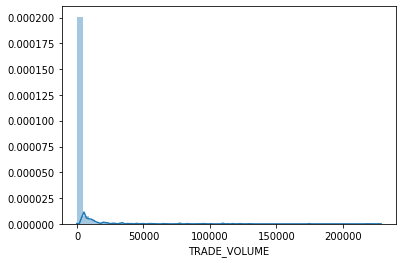

In [403]:
sns.distplot(vizdf["TRADE_VOLUME"]);

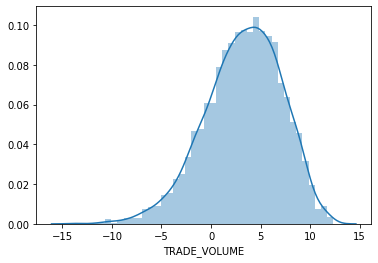

In [404]:
sns.distplot(vizdf["TRADE_VOLUME"].apply(np.log));

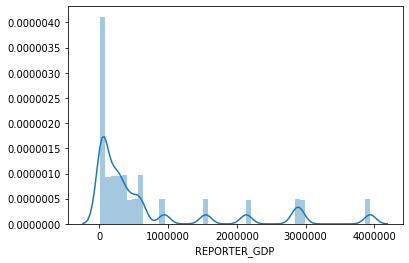

In [405]:
sns.distplot(vizdf["REPORTER_GDP"]);

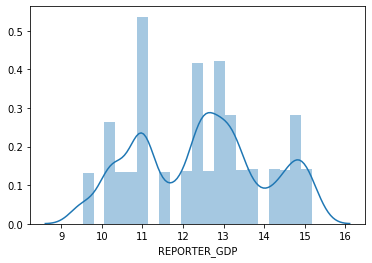

In [406]:
sns.distplot(vizdf["REPORTER_GDP"].apply(np.log));

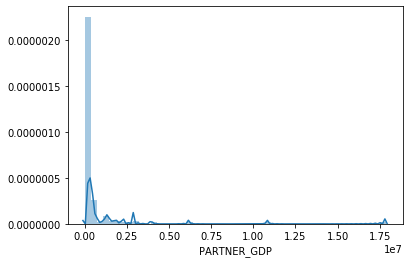

In [407]:
sns.distplot(vizdf["PARTNER_GDP"]);

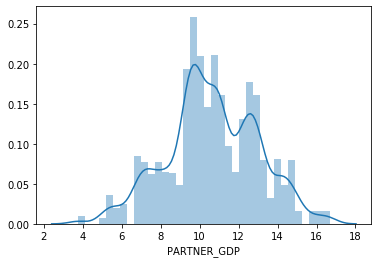

In [408]:
sns.distplot(vizdf["PARTNER_GDP"].apply(np.log));

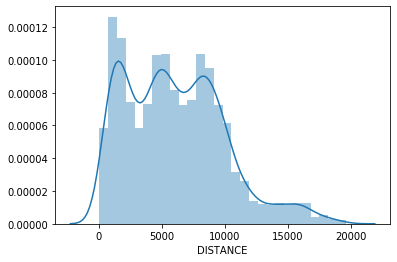

In [409]:
sns.distplot(vizdf["DISTANCE"]);

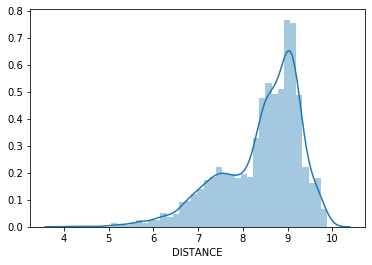

In [410]:
sns.distplot(vizdf["DISTANCE"].apply(np.log));

In [411]:
vizdf2 = vizdf[vizdf["REPORTER_ISO"] == "DE"]

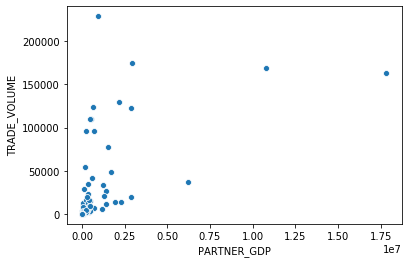

In [412]:
sns.scatterplot(x="PARTNER_GDP", y="TRADE_VOLUME", data=vizdf2)

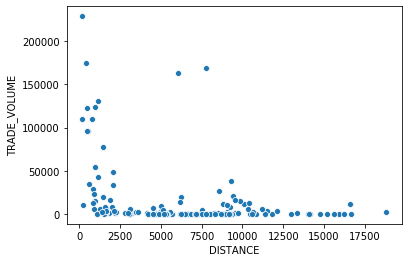

In [413]:
sns.scatterplot(x="DISTANCE", y="TRADE_VOLUME", data=vizdf2);

# add log transform to make it more visible

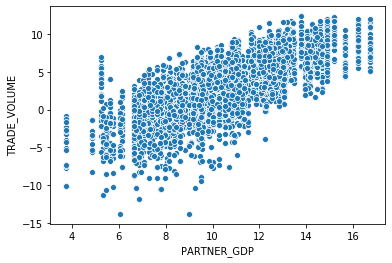

In [414]:
sns.scatterplot(x=vizdf["PARTNER_GDP"].apply(np.log), y=vizdf["TRADE_VOLUME"].apply(np.log));

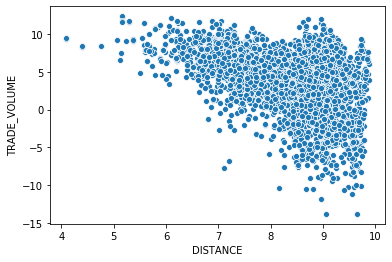

In [415]:
sns.scatterplot(x=vizdf["DISTANCE"].apply(np.log), y=vizdf["TRADE_VOLUME"].apply(np.log));

## Estimate basic gravity equation for 2018

In [416]:
# log transform features and trade volume? - its implicit in the equation

## Pipeline

In [417]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


In [418]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE
0,NL,IT,2018,I,34334.068495,9.481008e+05,2.138766e+06,1297.695,0,0,0
1,DE,SN,2018,E,129.730191,3.939227e+06,2.451909e+04,4643.462,0,0,0
2,DE,NG,2018,E,3166.323784,3.939227e+06,4.693768e+05,5020.854,0,0,0
3,IT,MM,2018,E,336.525420,2.138766e+06,8.442461e+04,8264.190,0,0,0
4,IE,HU,2018,I,684.070892,3.731415e+05,1.612189e+05,1895.995,1,0,0


In [419]:
data.filter(data.TRADE_VOLUME <= 0.001).count()
# deal with observations that are almost zero - how?

47

In [420]:
# log transform for trade volume, reporter gdp, partner gpd, distance
# add log transform to pipeline? possible?
# deal with observations that are almost zero - how?

from pyspark.sql import functions as F

data = data \
    .withColumn("TRADE_VOLUME_log", F.log(df.TRADE_VOLUME)) \
    .withColumn("REPORTER_GDP_log", F.log(df.REPORTER_GDP)) \
    .withColumn("PARTNER_GDP_log", F.log(df.PARTNER_GDP)) \
    .withColumn("DISTANCE_log", F.log(df.DISTANCE))

# use loop instead

In [421]:
data.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE,TRADE_VOLUME_log,REPORTER_GDP_log,PARTNER_GDP_log,DISTANCE_log
0,NL,IT,2018,I,34334.068495,9.481008e+05,2.138766e+06,1297.695,0,0,0,10.443893,13.762216,14.575740,7.168345
1,DE,SN,2018,E,129.730191,3.939227e+06,2.451909e+04,4643.462,0,0,0,4.865457,15.186495,10.107207,8.443215
2,DE,NG,2018,E,3166.323784,3.939227e+06,4.693768e+05,5020.854,0,0,0,8.060327,15.186495,13.059161,8.521355
3,IT,MM,2018,E,336.525420,2.138766e+06,8.442461e+04,8264.190,0,0,0,5.818674,14.575740,11.343614,9.019687
4,IE,HU,2018,I,684.070892,3.731415e+05,1.612189e+05,1895.995,1,0,0,6.528062,12.829713,11.990518,7.547499


### simple example just with gdp and distance

In [388]:
# Vector Assembler

features = ["REPORTER_GDP_log", "PARTNER_GDP_log", "DISTANCE_log"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

# trade volume, reporter gdp, partner gdp in mn EUR
# label indexer brauch ich nicht

In [422]:
data2 = assembler.transform(data)

In [423]:
model = LinearRegression(maxIter=100,
                         labelCol='TRADE_VOLUME_log', 
                         featuresCol='features')

# lr ohne elasticnet BS?

In [424]:
trained_model = model.fit(data2)

In [425]:
trained_model.numFeatures

3

In [426]:
features

['REPORTER_GDP_log', 'PARTNER_GDP_log', 'DISTANCE_log']

In [427]:
trained_model.coefficients

DenseVector([1.1579, 1.0884, -1.2583])

In [428]:
trained_model.summary.rootMeanSquaredError

1.6776109615147425

In [429]:
trained_model.summary.r2

0.8127295170155641

In [430]:
trained_model.summary.r2adj

0.8126071446677197

In [431]:
trained_model.summary.meanAbsoluteError

1.1960003167871855

In [432]:
trained_model.summary.pValues

[0.0, 0.0, 0.0, 0.0]

In [433]:
trained_model.summary.tValues

[72.89896776878669, 98.40096809024293, -42.96651087343902, -33.48972285201757]

In [434]:
trained_model.summary.coefficientStandardErrors

[0.015884188999981265,
 0.01106130902606986,
 0.029285209496649204,
 0.3624028752894219]

In [435]:
# only works with non elasticnet regresssion
# from https://runawayhorse001.github.io/LearningApacheSpark/regression.html

def modelsummary(model):
    import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary

    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))

    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", \
            Total iterations: %i"% Summary.totalIterations)

In [436]:
modelsummary(trained_model)

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##   1.157941   0.015884   72.899   0.000000
##   1.088444   0.011061   98.401   0.000000
##  -1.258283   0.029285  -42.967   0.000000
## -12.136772   0.362403  -33.490   0.000000
## ---
## Mean squared error:  2.814379 , RMSE:  1.677611
## Multiple R-squared: 0.812730 ,             Total iterations: 1


In [438]:
predictions = trained_model.transform(data2)


In [439]:
predictions.toPandas().head()

,REPORTER_ISO,PARTNER_ISO,YEAR,TRADE_TYPE,TRADE_VOLUME,REPORTER_GDP,PARTNER_GDP,DISTANCE,LANDLOCKED_ANY,COMMON_BORDER,COMMON_LANGUAGE,TRADE_VOLUME_log,REPORTER_GDP_log,PARTNER_GDP_log,DISTANCE_log,features,prediction
0,NL,IT,2018,I,34334.068495,9.481008e+05,2.138766e+06,1297.695,0,0,0,10.443893,13.762216,14.575740,7.168345,"[13.762216145603926, 14.575739664561027, 7.168...",10.644123
1,DE,SN,2018,E,129.730191,3.939227e+06,2.451909e+04,4643.462,0,0,0,4.865457,15.186495,10.107207,8.443215,"[15.186494971263052, 10.10720716859406, 8.4432...",5.825460
2,DE,NG,2018,E,3166.323784,3.939227e+06,4.693768e+05,5020.854,0,0,0,8.060327,15.186495,13.059161,8.521355,"[15.186494971263052, 13.059161087952296, 8.521...",8.940173
3,IT,MM,2018,E,336.525420,2.138766e+06,8.442461e+04,8264.190,0,0,0,5.818674,14.575740,11.343614,9.019687,"[14.575739664561027, 11.34361426943435, 9.0196...",5.738637
4,IE,HU,2018,I,684.070892,3.731415e+05,1.612189e+05,1895.995,1,0,0,6.528062,12.829713,11.990518,7.547499,"[12.829712880136695, 11.990518171454704, 7.547...",6.273388


In [ ]:
# trade_mn, gdp_mn, contig, comlang_off, distance

### treating this as prediction task

train test split, normalizer, predict, etc

https://spark.apache.org/docs/latest/ml-features#standardscaler

In [ ]:
# normalize features?